# Ensemble Methods

**Import dependencies**

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    StackingClassifier,
)
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

**Load and configure the dataset**

In [3]:
data = pd.read_csv("datasets/auction_data.csv")

data["total_capacity"] = (
    data["process.b1.capacity"]
    + data["process.b2.capacity"]
    + data["process.b3.capacity"]
    + data["process.b4.capacity"]
)
data.drop(
    columns=[
        "process.b1.capacity",
        "process.b2.capacity",
        "process.b3.capacity",
        "process.b4.capacity",
    ],
    inplace=True,
)

print(data.head())
print(data.info())
print(data.isnull().sum())

   property.price  property.product  property.winner  verification.result  \
0              59                 1                0                False   
1              59                 2                0                False   
2              59                 4                0                False   
3              59                 6                0                False   
4              60                 1                0                 True   

   verification.time  total_capacity  
0         163.316667               3  
1         200.860000               3  
2         154.888889               3  
3         108.640000               3  
4          85.466667               3  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property.price       2043 non-null   int64  
 1   property.product     2043 non-null   int64

**Scaling and preparing feature matrix (X) and target vector (y)**

In [4]:
scaler = StandardScaler()
X = data.drop(columns=["verification.result", "verification.time"])
y = data["verification.result"]
X_scaled = scaler.fit_transform(X)

**Split the data into training, validation, and test sets**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

**Model training**

In [6]:
# Random Forest base model training
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_pred)
print("Random Forest accuracy:", rf_accuracy)

# Gradient Boosting base model training
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_val)
gb_accuracy = accuracy_score(y_val, gb_pred)
print("Gradient Boosting accuracy:", gb_accuracy)

# Bagging base model training
bg_model = BaggingClassifier(random_state=42)
bg_model.fit(X_train, y_train)
bg_pred = bg_model.predict(X_val)
bg_accuracy = accuracy_score(y_val, bg_pred)
print("Bagging accuracy:", bg_accuracy)

Random Forest accuracy: 0.9766899766899767
Gradient Boosting accuracy: 0.9696969696969697
Bagging accuracy: 0.972027972027972


**Define parameter grids for RandomizedSearchCV**

In [7]:
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

gb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

bg_params = {
    "n_estimators": [50, 100, 200],
    "max_samples": [0.5, 1.0],
    "max_features": [0.5, 1.0],
}

**Perform RandomizedSearchCV for each base model**

In [8]:
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), rf_params, n_iter=10, cv=5, random_state=42
)
rf_random.fit(X_train, y_train)

gb_random = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    n_iter=10,
    cv=5,
    random_state=42,
)
gb_random.fit(X_train, y_train)

bg_random = RandomizedSearchCV(
    BaggingClassifier(random_state=42), bg_params, n_iter=10, cv=5, random_state=42
)
bg_random.fit(X_train, y_train)

print("\nBest parameters for Random Forest:", rf_random.best_params_)
print("Best parameters for Gradient Boosting:", gb_random.best_params_)
print("Best parameters for Bagging:", bg_random.best_params_)


Best parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best parameters for Gradient Boosting: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.05}
Best parameters for Bagging: {'n_estimators': 200, 'max_samples': 1.0, 'max_features': 1.0}


**Get best estimator models**

In [9]:
rf_best_model = rf_random.best_estimator_
gb_best_model = gb_random.best_estimator_
bg_best_model = bg_random.best_estimator_

**Evaluate model accuracy on the validation set**

In [10]:
rf_val_pred = rf_best_model.predict(X_val)
gb_val_pred = gb_best_model.predict(X_val)
bg_val_pred = bg_best_model.predict(X_val)

rf_val_accuracy = accuracy_score(y_val, rf_val_pred)
gb_val_accuracy = accuracy_score(y_val, gb_val_pred)
bg_val_accuracy = accuracy_score(y_val, bg_val_pred)

print("\nRandom Forest accuracy on the validation set:", rf_val_accuracy)
print("Gradient Boosting accuracy on the validation set:", gb_val_accuracy)
print("Bagging accuracy on the validation set:", bg_val_accuracy)


Random Forest accuracy on the validation set: 0.9743589743589743
Gradient Boosting accuracy on the validation set: 0.9766899766899767
Bagging accuracy on the validation set: 0.9743589743589743


**Evaluate model accuracy on the test set**

In [11]:
rf_test_pred = rf_best_model.predict(X_test)
gb_test_pred = gb_best_model.predict(X_test)
bg_test_pred = bg_best_model.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, rf_test_pred)
gb_test_accuracy = accuracy_score(y_test, gb_test_pred)
bg_test_accuracy = accuracy_score(y_test, bg_test_pred)

print("\nRandom Forest accuracy on the test set:", rf_test_accuracy)
print("Gradient Boosting accuracy on the test set:", gb_test_accuracy)
print("Bagging accuracy on the test set:", bg_test_accuracy)


Random Forest accuracy on the test set: 0.9722675367047309
Gradient Boosting accuracy on the test set: 0.9690048939641109
Bagging accuracy on the test set: 0.9706362153344209


**Perform stacking**

In [12]:
estimators = [("rf", rf_best_model), ("gb", gb_best_model), ("bg", bg_best_model)]

stacking_classifier = StackingClassifier(
    estimators=estimators, final_estimator=DecisionTreeClassifier()
)
stacking_classifier.fit(X_train, y_train)

stacking_val_pred = stacking_classifier.predict(X_val)
stacking_val_accuracy = accuracy_score(y_val, stacking_val_pred)
print("\nStacking accuracy on the validation set:", stacking_val_accuracy)

stacking_test_pred = stacking_classifier.predict(X_test)
stacking_test_accuracy = accuracy_score(y_test, stacking_test_pred)
print("Stacking accuracy on the test set:", stacking_test_accuracy)


Stacking accuracy on the validation set: 0.9440559440559441
Stacking accuracy on the test set: 0.9396411092985318


**Visualization**

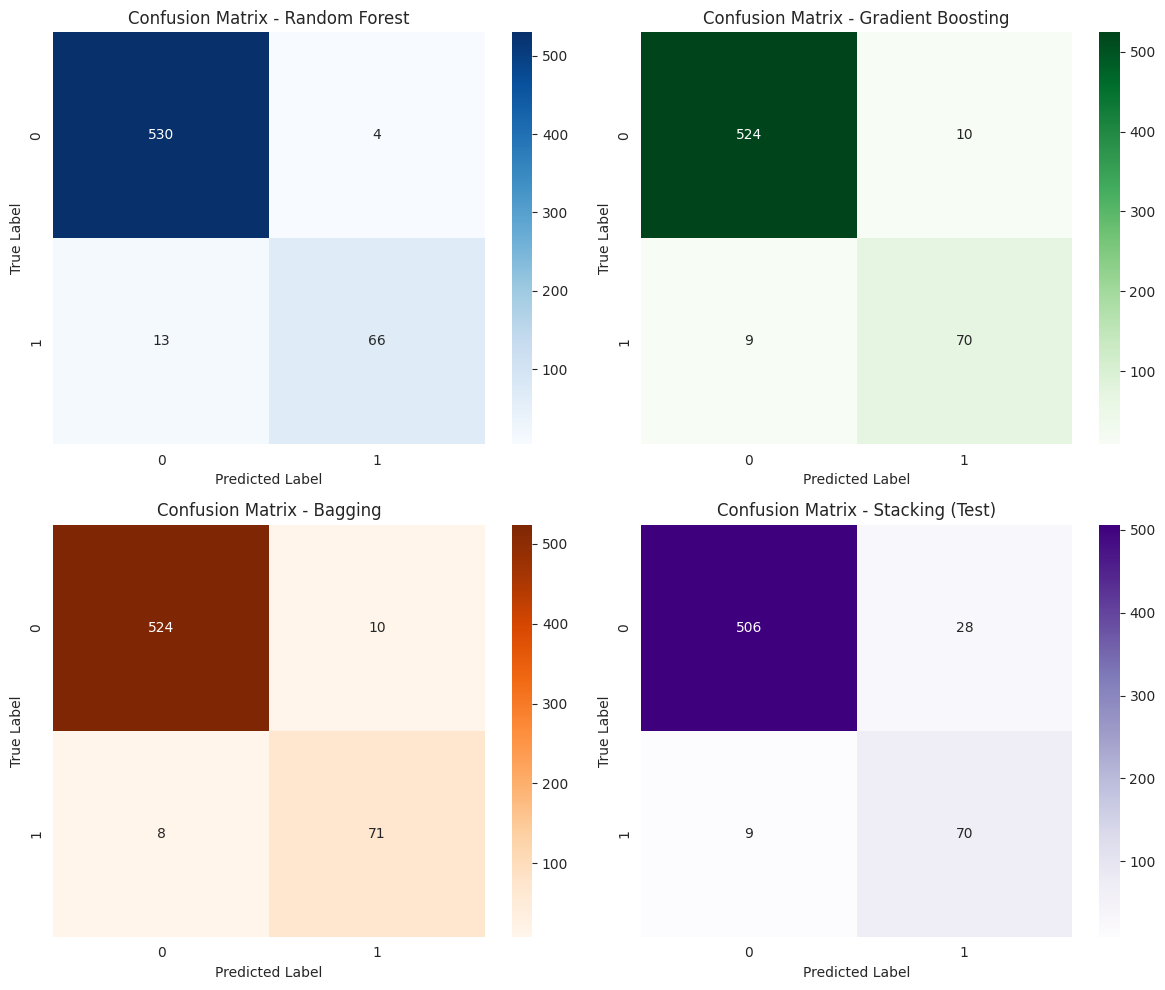

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Confusion Matrix - Random Forest
sns.heatmap(confusion_matrix(y_test, rf_test_pred), annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix - Random Forest")
axes[0, 0].set_xlabel("Predicted Label")
axes[0, 0].set_ylabel("True Label")

# Plot Confusion Matrix - Gradient Boosting
sns.heatmap(confusion_matrix(y_test, gb_test_pred), annot=True, fmt="d", cmap="Greens", ax=axes[0, 1])
axes[0, 1].set_title("Confusion Matrix - Gradient Boosting")
axes[0, 1].set_xlabel("Predicted Label")
axes[0, 1].set_ylabel("True Label")

# Plot Confusion Matrix - Bagging
sns.heatmap(confusion_matrix(y_test, bg_test_pred), annot=True, fmt="d", cmap="Oranges", ax=axes[1, 0])
axes[1, 0].set_title("Confusion Matrix - Bagging")
axes[1, 0].set_xlabel("Predicted Label")
axes[1, 0].set_ylabel("True Label")

# Plot Confusion Matrix - Stacking (Test)
sns.heatmap(confusion_matrix(y_test, stacking_test_pred), annot=True, fmt="d", cmap="Purples", ax=axes[1, 1])
axes[1, 1].set_title("Confusion Matrix - Stacking (Test)")
axes[1, 1].set_xlabel("Predicted Label")
axes[1, 1].set_ylabel("True Label")

plt.tight_layout()
plt.show()